In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

d:\Anaconda3\envs\pydml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("dml")

In [6]:
torch.cuda.is_available()

False

In [7]:
torch.tensor([[1, 2, 3], [1, 2, 3]]).to(device)

tensor([[1, 2, 3],
        [1, 2, 3]], device='dml')

In [12]:
batch_size = 32
train_datasets = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=False)
test_datasets = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=False)
train_data = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_datasets, batch_size=batch_size, shuffle=True)

In [9]:
description = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

airplane


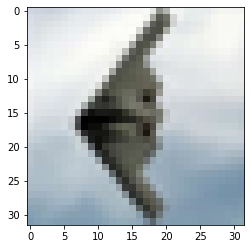

In [10]:
images, labels = next(iter(test_data))
plt.imshow(images[0].permute(1, 2, 0))
print(description[labels[0].item()])

In [11]:
def caculate_infos(size,parameters):
    return (parameters[1],((size-parameters[2]+2*parameters[4])/parameters[3])+1)
caculate_infos(16,(256,512,3,1,1))


(512, 16.0)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 64,16*16
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 128,8*8
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 256,4*4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # 512,2*2
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        ) # 512,1*1
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Linear(128,10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

net = CNN()
net = net.to(device)

In [14]:
loss_function = nn.CrossEntropyLoss()

In [16]:
def train(epochs=1, learning_rate=0.001):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    lr_schedule = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, cooldown=1)
    max_record = 0.41275 # 手动修改
    net.load_state_dict(torch.load('CNN-CIFAR10-dml.pkl'))
    for epoch in range(epochs):
        net.train()
        for i, (images, labels) in enumerate(train_data):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        

        total = 10000
        correct = 0
        net.eval()
        for i, (images, labels) in enumerate(test_data):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.tolist()
            outputs = net(images)
            predict = torch.max(outputs,1).indices.tolist()
            total += len(predict)
            for i in range(len(predict)):
                if predict[i] == labels[i]:
                    correct += 1
        
        if correct/total>max_record:
            max_record = correct/total
            net.to("cpu")
            torch.save(net.state_dict(),'CNN-CIFAR10-dml.pkl')
            net.to(device)
            print(f"epoch {epoch}: {max_record} 已保存")
        else:
            print(f"epoch {epoch}: {correct/total}")
            
        lr_schedule.step(correct/total)

train(10, learning_rate=0.001)


epoch 0: 0.3963
epoch 1: 0.397
epoch 2: 0.4076 已保存
epoch 3: 0.40975 已保存
epoch 4: 0.41015 已保存
epoch 5: 0.4106 已保存
epoch 6: 0.4122 已保存
epoch 7: 0.41275 已保存
epoch 8: 0.41215
epoch 9: 0.4105


In [19]:
# net.to("cpu")
# torch.save(net.state_dict(),'CNN-CIFAR10-dml.pkl')

In [11]:
total = 10000
correct = 0
for i, (images, labels) in enumerate(test_data):
    images = images.to(device)
    labels = labels.tolist()
    outputs = net(images)
    predict = torch.max(outputs,1).indices.tolist()
    total += len(predict)
    for i in range(len(predict)):
        if predict[i] == labels[i]:
            correct += 1
print(f" {correct/total*100}%")

 5.015%


In [ ]:
# test for git a